In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from dateutil.relativedelta import relativedelta

In [4]:
class OilProductionPredictor:
    def __init__(self, data_path, window=3):
        self.df = pd.read_csv(data_path)
        self.window = window
        self.scaler = MinMaxScaler()
        self.model = None
        self.x_train = None
        self.y_train = None
        self.x_val = None
        self.y_val = None
        self.x_test = None
        self.y_test = None
        self.new_df = None
        self.future_df = None
        
        self.df['Date'] = pd.to_datetime(self.df['Date'])
        last_date = self.df['Date'].max()
        next_month = last_date + pd.DateOffset(months=1)
        self.start_date = next_month.strftime('%Y-%m-%d')
        self.end_date = (last_date + relativedelta(years=2)).strftime('%Y-%m-%d')

    def preprocess_data(self):
        self.df.dropna(axis=0,inplace=True)
        self.df.rename(columns={self.df.columns[1]: 'Production'}, inplace=True)

        self.df['Production'] = self.scaler.fit_transform(self.df['Production'].values.reshape(-1, 1))

        for i in range(self.window):
            col_name = 'Feature_' + str(i)
            self.df[col_name] = np.nan
        self.df['Label'] = np.nan

        for i in range(len(self.df['Production'])):
            for j in range(self.window):
                try:
                    self.df.loc[i:i, 'Feature_' + str(j)] = self.df['Production'][i - self.window + j]
                except:
                    self.df.loc[i:i, 'Feature_' + str(j)] = 0
            self.df.loc[i:i, 'Label'] = self.df['Production'][i]

    def split_data(self, test_size=0.2, val_size=0.5):
        x = self.df.drop(['Date', 'Production', 'Label'], axis='columns')
        y = self.df['Label']

        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, shuffle=False)
        x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=val_size, shuffle=False)

        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val
        self.x_test = x_test
        self.y_test = y_test

    def build_model(self):
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)

        model = keras.Sequential([
            keras.layers.Dense(64, input_shape=(self.window,), activation='relu'),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(32, activation='tanh'),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(1)
        ])
        model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['acc'])

        self.model = model

    def train_model(self, epochs=100, batch_size=32):
        self.model.fit(self.x_train, self.y_train, validation_data=(self.x_val, self.y_val),
                       epochs=epochs, batch_size=batch_size)

    def make_predictions(self):
        train_predictions = self.model.predict(self.x_train.values)
        val_predictions = self.model.predict(self.x_val.values)
        test_predictions = self.model.predict(self.x_test.values)

        self.new_df = pd.DataFrame()
        self.new_df['Original_Production'] =self.scaler.inverse_transform(self.df['Production'].values.reshape(-1, 1)).flatten()
        date_col = self.df.loc[self.new_df.index, 'Date']
        self.new_df.insert(0, 'Date', None)
        self.new_df['Date'] = date_col
        self.new_df['Predictions'] = np.nan

        self.new_df.loc[0:self.x_train.shape[0] - 1, 'Predictions'] = self.scaler.inverse_transform(
            train_predictions).reshape(self.x_train.shape[0], )
        self.new_df.loc[self.x_train.shape[0]:self.x_train.shape[0] + self.x_val.shape[0] - 1, 'Predictions'] = \
            self.scaler.inverse_transform(val_predictions).reshape(self.x_val.shape[0], )
        self.new_df.loc[
        self.x_train.shape[0] + self.x_val.shape[0]:self.x_train.shape[0] + self.x_val.shape[0] + self.x_test.shape[
            0] - 1, 'Predictions'] = self.scaler.inverse_transform(test_predictions).reshape(self.x_test.shape[0], )

    def predict_future(self):
        future_dates = pd.date_range(start=self.start_date, end=self.end_date, freq='MS')
        future_df = pd.DataFrame({'Date': future_dates})
        future_df['Production'] = np.nan
        future_df['Normalized'] = np.nan

        desired_df = self.new_df.iloc[len(self.new_df) - self.window:len(self.new_df)].copy()
        desired_df.drop(['Predictions'], axis='columns', inplace=True)
        desired_df.rename(columns={'Original_Production': 'Production'}, inplace=True)
        desired_df['Normalized'] = np.nan
        for i in range(self.window):
            desired_df.loc[len(self.new_df) - self.window + i, 'Normalized'] = \
                self.df['Production'].iloc[len(self.new_df) - self.window + i]

        future_df = pd.concat([desired_df, future_df], ignore_index=True)

        for i in range(len(future_df['Production']) - self.window):
            arr = np.array(future_df['Normalized'].iloc[i:i + self.window]).reshape(1, -1)
            predicted_value = self.model.predict(arr)
            future_df.loc[i + self.window, 'Normalized'] = predicted_value[0][0]
            future_df.loc[i + self.window, 'Production'] = self.scaler.inverse_transform(predicted_value)[0][0]

        self.future_df = future_df
        print(self.future_df)

    def plot_results(self):
        plt.figure(figsize=(20, 8))
        plt.plot(self.new_df['Date'], self.new_df['Original_Production'], label='Original')
        plt.plot(self.new_df.loc[0:self.x_train.shape[0] - 1, 'Date'], self.new_df.loc[0:self.x_train.shape[0] - 1, 'Predictions'], label='Train')
        plt.plot(self.new_df.loc[self.x_train.shape[0]:self.x_train.shape[0] + self.x_val.shape[0] - 1, 'Date'], self.new_df.loc[self.x_train.shape[0]:self.x_train.shape[0] + self.x_val.shape[0] - 1, 'Predictions'], label='Val')
        plt.plot(self.new_df.loc[self.x_train.shape[0] + self.x_val.shape[0]:self.x_train.shape[0] + self.x_val.shape[0] + self.x_test.shape[0] - 1, 'Date'], self.new_df.loc[self.x_train.shape[0] + self.x_val.shape[0]:self.x_train.shape[0] + self.x_val.shape[0] + self.x_test.shape[0] - 1, 'Predictions'], label='Test')
        plt.plot(self.future_df['Date'], self.future_df['Production'], label='Future')
        plt.xticks(rotation=45)
        plt.xlabel('Year')
        plt.ylabel('Production (Thousand Barrel/Month)')
        plt.legend(loc='upper left')
        plt.tight_layout()
        plt.show()
        
    def plot_future(self):
        plt.figure(figsize=(20, 8))
        plt.plot(self.future_df['Date'], self.future_df['Production'], label='Future')
        plt.xticks(rotation=45)
        plt.xlabel('Year')
        plt.ylabel('Production (Thousand Barrel/Month)')
        plt.legend(loc='upper left')
        plt.tight_layout()
        plt.show()
        
    def query_to_see_predictions(self, start_date, end_date):
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)

        mask = (self.new_df['Date'] >= start_date) & (self.new_df['Date'] <= end_date)
        predictions_df = self.new_df.loc[mask, ['Date', 'Original_Production', 'Predictions']]
        print(predictions_df)
        
    def calculate_average_production(self, start_year, end_year):
        mask_before = (self.df['Date'].dt.year >= start_year) & (self.df['Date'].dt.year < 2012)
        mask_after = (self.df['Date'].dt.year >= 2012) & (self.df['Date'].dt.year <= end_year)

        average_before = self.df.loc[mask_before, 'Production'].mean()
        average_after = self.df.loc[mask_after, 'Production'].mean()

        return average_before, average_after
    
    def production_comparison(self):
        avg_before, avg_after = self.calculate_average_production(1920, 2023)
        threshold = 0.5
        
        low_production_threshold = 25000
        low_production_count = (self.new_df['Original_Production'] < low_production_threshold).sum()
        
        if low_production_count<=10:
            print("This is a high crude oil production state!")
            return None

        print("Normalized average production before 2012:", avg_before)
        print("Normalized average production after 2012:", avg_after)
        print()

        if avg_before < threshold:
            print("The state was low producing before 2012.")
        else:
            print("The state was high producing before 2012.")

        if avg_after >= threshold:
            print("The state is high producing after 2012.")
        else:
            print("The state is low producing after 2012.")
    
    def production_trend_of_future(self):
        threshold = 0.5

        is_low_producing = self.future_df['Normalized'] < threshold
        is_high_producing = self.future_df['Normalized'] >= threshold

        if is_low_producing.all():
            print("The state is consistently low producing in the future.")
        elif is_high_producing.all():
            print("The state is consistently high producing in the future.")
        else:
            low_producing_ranges = self._get_production_ranges(is_low_producing)
            high_producing_ranges = self._get_production_ranges(is_high_producing)

            print("Ranges of low production in the future:")
            for start_year, end_year in low_producing_ranges:
                print(f"From {start_year} to {end_year}")

            print("\nRanges of high production in the future:")
            for start_year, end_year in high_producing_ranges:
                print(f"From {start_year} to {end_year}")

    def _get_production_ranges(self, boolean_series):
        ranges = []
        start_year, end_year = None, None
        for i, value in enumerate(boolean_series):
            if value:
                if start_year is None:
                    start_year = self.future_df['Date'].iloc[i].date()
            else:
                if start_year is not None:
                    end_year = self.future_df['Date'].iloc[i - 1].date()
                    ranges.append((start_year, end_year))
                    start_year, end_year = None, None

        if start_year is not None:
            end_year = self.future_df['Date'].iloc[-1].date()
            ranges.append((start_year, end_year))

        return ranges

In [5]:
predictor = OilProductionPredictor(
    "C:\\Users\\ghsay\\OneDrive\\Desktop\\Crude-oil-production-usa\\PADD-2\\Tennessee-Crude-oil-production.csv"
)

In [6]:
predictor.preprocess_data()
predictor.split_data()
predictor.build_model()
predictor.train_model()

Epoch 1/100
13/13 [==============================] - 1s 12ms/step - loss: 0.1521 - acc: 0.0000e+00 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 2/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0586 - acc: 0.0025 - val_loss: 0.0099 - val_acc: 0.0000e+00
Epoch 3/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0582 - acc: 0.0025 - val_loss: 0.0044 - val_acc: 0.0000e+00
Epoch 4/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0465 - acc: 0.0025 - val_loss: 0.0027 - val_acc: 0.0000e+00
Epoch 5/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0399 - acc: 0.0025 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 6/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0317 - acc: 0.0025 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 7/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0271 - acc: 0.0049 - val_loss: 9.9936e-04 - val_acc: 0.0000e+00
Epoch 8/100
13/13 [===========================

Epoch 61/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0108 - acc: 0.0025 - val_loss: 0.0025 - val_acc: 0.0000e+00
Epoch 62/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0079 - acc: 0.0049 - val_loss: 0.0033 - val_acc: 0.0000e+00
Epoch 63/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0069 - acc: 0.0049 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 64/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0082 - acc: 0.0049 - val_loss: 0.0022 - val_acc: 0.0000e+00
Epoch 65/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0086 - acc: 0.0049 - val_loss: 0.0020 - val_acc: 0.0000e+00
Epoch 66/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0095 - acc: 0.0049 - val_loss: 0.0019 - val_acc: 0.0000e+00
Epoch 67/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0073 - acc: 0.0049 - val_loss: 0.0034 - val_acc: 0.0000e+00
Epoch 68/100
13/13 [============================

In [7]:
predictor.make_predictions()

2/2 [==============================] - 0s 4ms/step


In [8]:
predictor.predict_future()

1/1 [==============================] - 0s 14ms/step
         Date  Production  Normalized
0  2023-02-01    8.000000    0.000000
1  2023-03-01   11.000000    0.029412
2  2023-04-01   11.000000    0.029412
3  2023-05-01   31.474232    0.230140
4  2023-06-01   35.875832    0.273292
5  2023-07-01   36.354137    0.277982
6  2023-08-01   32.576241    0.240944
7  2023-09-01   32.594559    0.241123
8  2023-10-01   32.028076    0.235569
9  2023-11-01   31.110098    0.226570
10 2023-12-01   30.688221    0.222434
11 2024-01-01   30.280313    0.218434
12 2024-02-01   29.925018    0.214951
13 2024-03-01   29.687593    0.212623
14 2024-04-01   29.536219    0.211139
15 2024-05-01   29.444931    0.210244
16 2024-06-01   29.394815    0.209753
17 2024-07-01   29.368475    0.209495
18 2024-08-01   29.355024    0.209363
19 2024-09-01   29.348251    0.209297
20 2024-10-01   29.344879    0.209264
21 2024-11-01   29.343214    0.209247
22 2024-12-01   29.342390    0.209239
23 2025-01-01   29.341986    0.20923

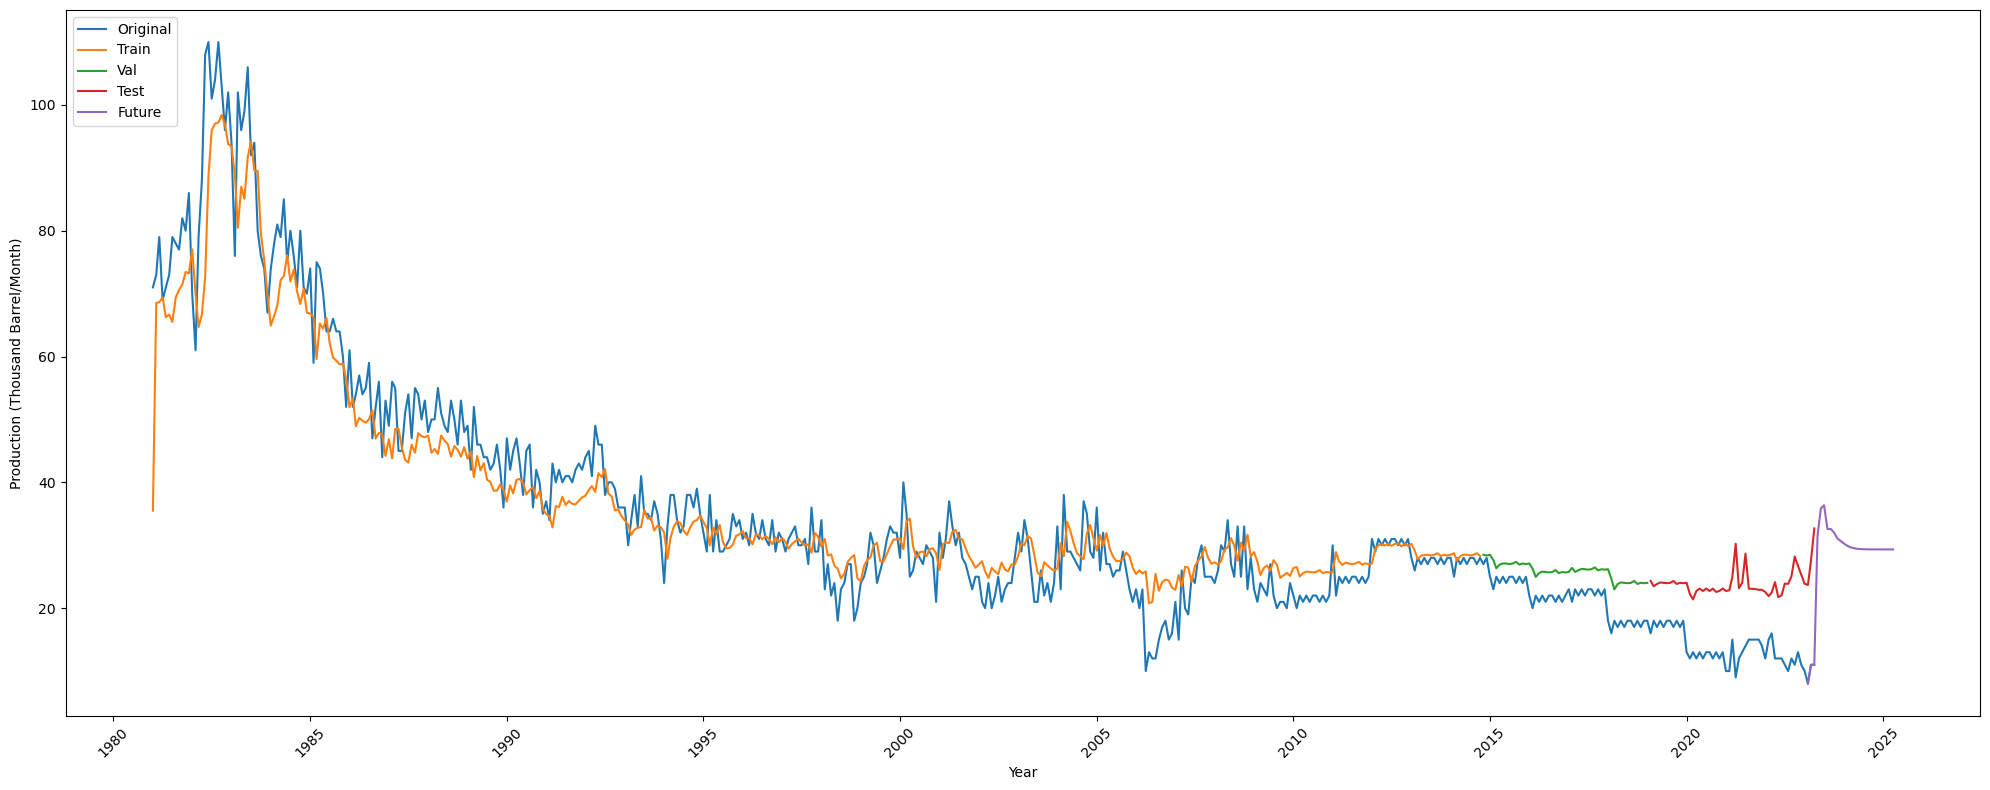

In [9]:
predictor.plot_results()

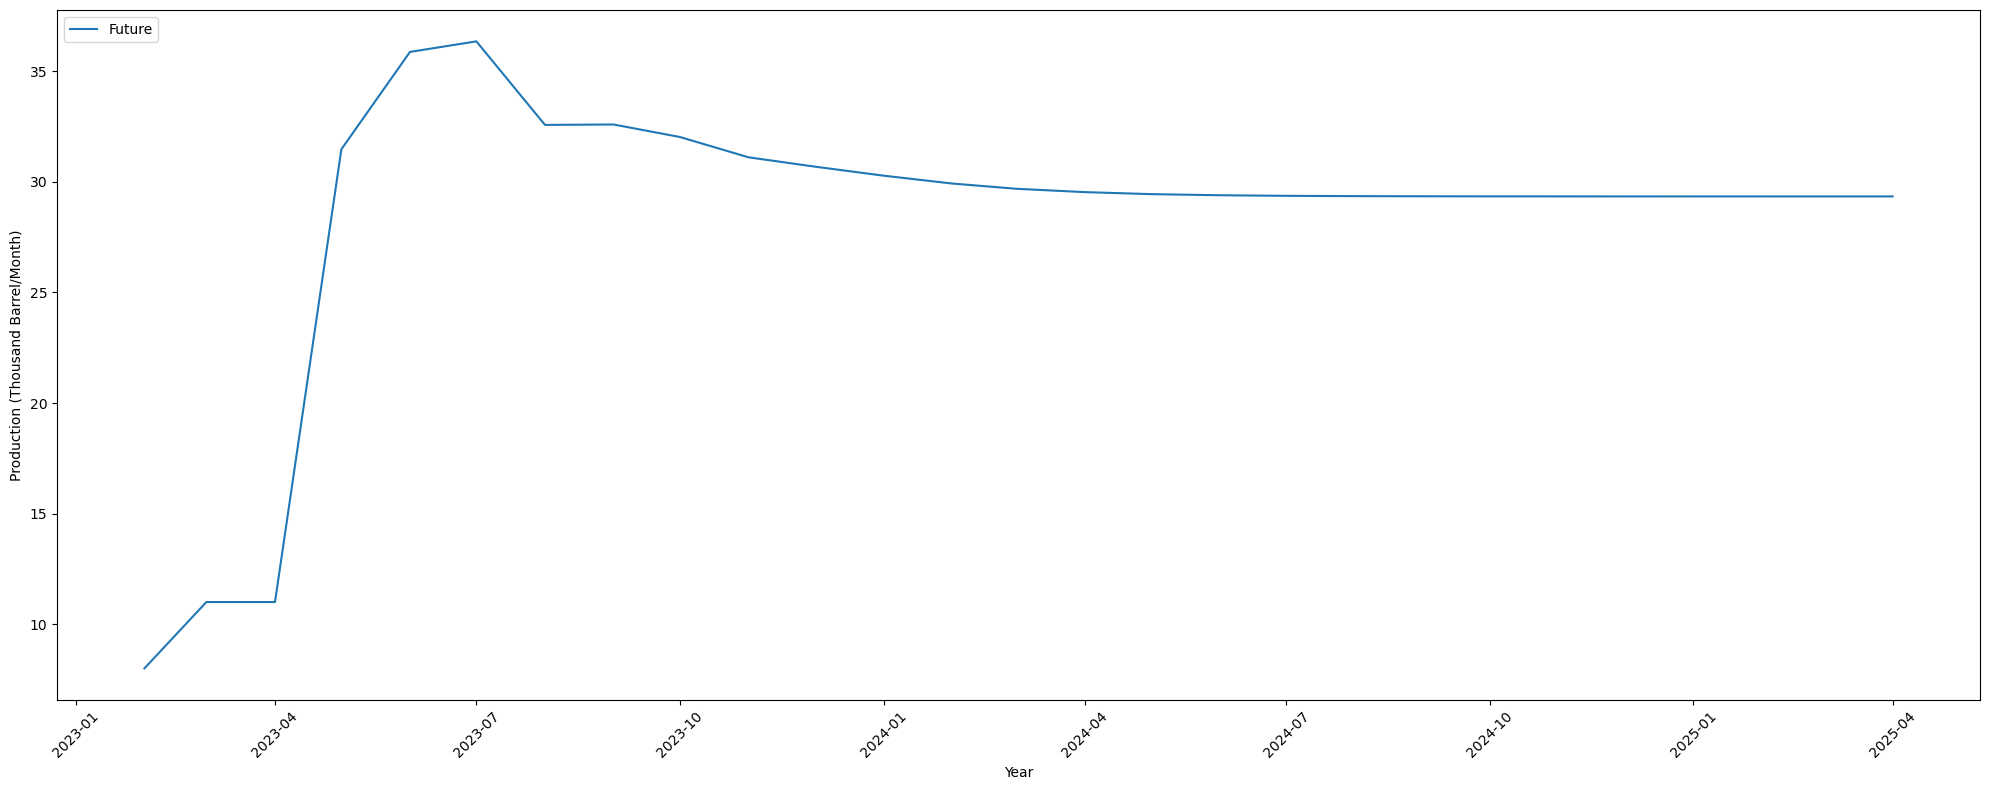

In [10]:
predictor.plot_future()

In [11]:
predictor.query_to_see_predictions('2016-01-01','2016-12-01')

          Date  Original_Production  Predictions
420 2016-01-01                 22.0    27.111403
421 2016-02-01                 20.0    26.276001
422 2016-03-01                 22.0    24.965067
423 2016-04-01                 21.0    25.561417
424 2016-05-01                 22.0    25.809364
425 2016-06-01                 21.0    25.743990
426 2016-07-01                 22.0    25.690985
427 2016-08-01                 22.0    25.743990
428 2016-09-01                 21.0    26.051086
429 2016-10-01                 22.0    25.572607
430 2016-11-01                 21.0    25.743990
431 2016-12-01                 22.0    25.690985


In [12]:
predictor.production_comparison()

Normalized average production before 2012: 0.3143316466371496
Normalized average production after 2012: 0.12067474048442897

The state was low producing before 2012.
The state is low producing after 2012.


In [13]:
predictor.production_trend_of_future()

The state is consistently low producing in the future.
